# Chapter 2

https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tf_helpers import *

/Users/spencer/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Setup tf eager: True


In [3]:
lambda_1 = tfd.Exponential(rate=1., name="lambda_1") #stochastic variable
lambda_2 = tfd.Exponential(rate=1., name="lambda_2") #stochastic variable
tau = tfd.Uniform(name="tau", low=0., high=10.) #stochastic variable

# deterministic variable since we are getting results of lambda's after sampling    
new_deterministic_variable = tfd.Deterministic(name="deterministic_variable", 
                                               loc=(lambda_1.sample() + lambda_2.sample()))

new_deterministic_variable.sample(), new_deterministic_variable.sample()

(<tf.Tensor: id=74, shape=(), dtype=float32, numpy=0.49066353>,
 <tf.Tensor: id=93, shape=(), dtype=float32, numpy=0.49066353>)

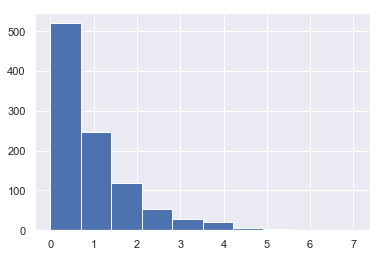

In [4]:
plt.hist(lambda_1.sample((1000)).numpy());

# A/B Test

[link](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb#Example:-Bayesian-A/B-testing)

## Fake Data

/Users/spencer/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


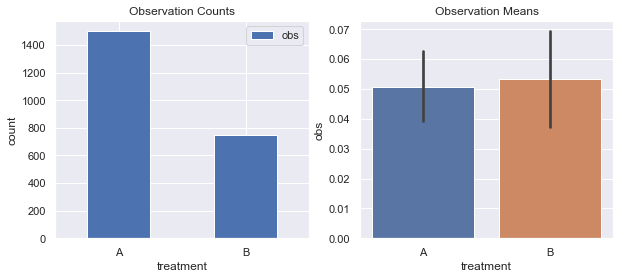

In [5]:
RAND_SEED = 6.45

#these two quantities are unknown to us.
TRUE_A = 0.05
TRUE_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
obs_A = tfd.Bernoulli(name="obs_A", probs=TRUE_A).sample(sample_shape=N_A, seed=RAND_SEED)
obs_B = tfd.Bernoulli(name="obs_B", probs=TRUE_B).sample(sample_shape=N_B, seed=RAND_SEED)

[ 
    obs_A_,
    obs_B_,
] = eval_tensor([ 
    obs_A, 
    obs_B, 
])

df_A = pd.DataFrame(data=obs_A_, columns=['obs'])
df_A['treatment'] = 'A'
df_B = pd.DataFrame(data=obs_B_, columns=['obs'])
df_B['treatment'] = 'B'

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = pd.concat((df_A, df_B)).groupby('treatment').count().plot.bar(ax=axes[0])
ax.set_ylabel('count')
ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')
ax.set_title('Observation Counts');

ax = sns.barplot(data=pd.concat((df_A, df_B)), x='treatment', y='obs', ax=axes[1])
ax.set_title('Observation Means');

In [6]:
def unnormalized_posterior_log_prob(prob_A, prob_B):
    """
    Joint log probability optimization function.
        
    Args:
      prob_A: scalar estimate of the probability of a 1 appearing in 
                observation set A
      prob_B: scalar estimate of the probability of a 1 appearing in 
                observation set B 
    Returns: 
      Joint log probability optimization function.
    """  
    # Could assume something else here
    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_prob_B = tfd.Uniform(low=0., high=1.)
  
    rv_obs_A = tfd.Bernoulli(probs=prob_A)
    rv_obs_B = tfd.Bernoulli(probs=prob_B)
  
    # Function to optimize
    return (
        rv_prob_A.log_prob(prob_A)
        + rv_prob_B.log_prob(prob_B)
        + tf.reduce_sum(rv_obs_A.log_prob(obs_A_))
        + tf.reduce_sum(rv_obs_B.log_prob(obs_B_))
    )

In [7]:
# Modeling

number_of_steps = 1800
burnin = 1000
leapfrog_steps = 3

initial_chain_state = [    
    tf.convert_to_tensor(obs_A_.mean(), dtype=tf.float32, name="init_prob_A"),
    tf.convert_to_tensor(obs_B_.mean(), dtype=tf.float32, name="init_prob_B"),
]

unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
]

# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True,
    )

In [8]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior_log_prob,
    num_leapfrog_steps=leapfrog_steps,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(None),
    state_gradients_are_stopped=True,
)

hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=unconstraining_bijectors,
)

posterier, kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc,
)

[posterior_prob_A, posterior_prob_B] = posterier

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
eval_tensor(init_g)
eval_tensor(init_l)
[
    posterior_prob_A_,
    posterior_prob_B_,
    kernel_results_,
] = eval_tensor([
    posterior_prob_A,
    posterior_prob_B,
    kernel_results,
])
    
burned_prob_A_trace_ = posterior_prob_A_[burnin:]
burned_prob_B_trace_ = posterior_prob_B_[burnin:]
burned_delta_trace_ = (posterior_prob_A_ - posterior_prob_B_)[burnin:]

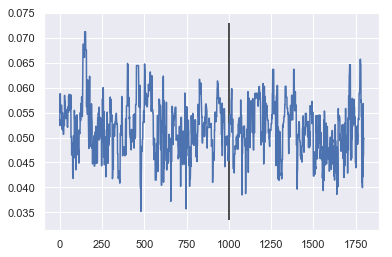

In [10]:
fig, ax = plt.subplots()
plt.plot(posterior_prob_A_)
ax.vlines(burnin, *ax.get_ylim())

In [11]:
kernel_results_.inner_results.is_accepted.mean()

0.5894444444444444

/Users/spencer/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Cumulative distribution of difference')

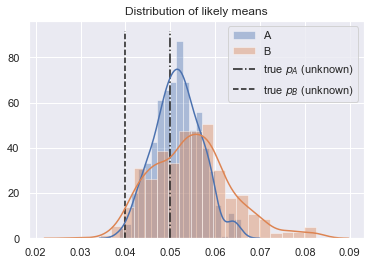

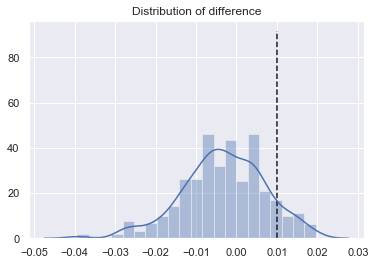

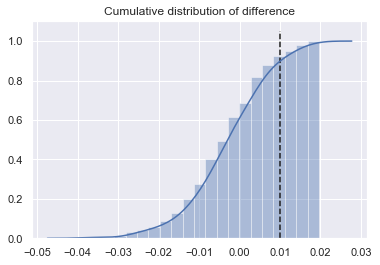

In [12]:
ax = sns.distplot(burned_prob_A_trace_, label='A')
sns.distplot(burned_prob_B_trace_, label='B', ax=ax)

lim = ax.get_ylim()
ax.vlines(TRUE_A, *lim, linestyle="-.", label="true $p_A$ (unknown)")
ax.vlines(TRUE_B, *lim, linestyle="--", label="true $p_B$ (unknown)")

ax.legend()
ax.set_title('Distribution of likely means')

fig, ax = plt.subplots()
sns.distplot(burned_delta_trace_, label='B', ax=ax)
ax.vlines(TRUE_A - TRUE_B, *lim, linestyle="--", label="true $p_B$ (unknown)")
ax.set_title('Distribution of difference')

fig, ax = plt.subplots()
sns.distplot(burned_delta_trace_, label='B', ax=ax, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
lim = ax.get_ylim()
ax.vlines(TRUE_A - TRUE_B, *lim, linestyle="--", label="true $p_B$ (unknown)")
ax.set_title('Cumulative distribution of difference')

# Challenger O-Rings

https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50

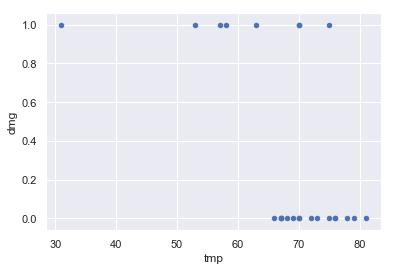

In [30]:
import wget
url = (
    'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers'
    '/master/Chapter2_MorePyMC/data/challenger_data.csv'
)
filename = wget.download(url)

challenger = pd.read_csv(filename)[['Temperature', 'Damage Incident']]
challenger.columns = ['tmp', 'dmg']
challenger = challenger.dropna()
challenger = challenger.replace('Challenger Accident', 1)
challenger['dmg'] = challenger['dmg'].astype(int)
challenger.plot.scatter(x='tmp', y='dmg')

In [ ]:
def challenger_joint_log_prob(D, temp, alpha, beta):
    rv_alpha = tfd.Normal(loc=0., scale=1000.)
    rv_beta = tfd.Normal(loc=0., scale=1000.)
    logistic_p = 1.0 / (1. + tf.exp(beta * tf.to_float(temp) + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
  
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(D))
    )